In [359]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 125
import seaborn as sns
from Bio import SeqIO, Seq
import scipy.stats as st
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import glob, os, yaml, subprocess, itertools, sparse

who_variants_combined = pd.read_csv("who_confidence_2021.csv")
samples_summary = pd.read_csv("../data/samples_summary.csv")

import warnings
warnings.filterwarnings(action='ignore')
from stats_utils import *

# CHANGE ANALYSIS DIR BEFORE RUNNING THE NOTEBOOK!
analysis_dir = '/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue'

In [360]:
drugs_lst = os.listdir(analysis_dir)

drug_abbr_dict = {"Delamanid": "DLM",
                  "Bedaquiline": "BDQ",
                  "Clofazimine": "CFZ",
                  "Ethionamide": "ETH",
                  "Linezolid": "LZD",
                  "Moxifloxacin": "MXF",
                  "Capreomycin": "CAP",
                  "Amikacin": "AMI",
                  "Pretomanid": "PTM",
                  "Pyrazinamide": "PZA",
                  "Kanamycin": "KAN",
                  "Levofloxacin": "LEV",
                  "Streptomycin": "STM",
                  "Ethambutol": "EMB",
                  "Isoniazid": "INH",
                  "Rifampicin": "RIF"
                 }

In [361]:
# check that all the dropped features folders have been updated
for drug in np.sort(drugs_lst):
    
    if drug == "Pretomanid":
        model_path = "tiers=1/phenos=ALL"
    else:
        model_path = "tiers=1+2/phenos=ALL"
        
    if len(os.listdir(os.path.join(analysis_dir, drug, f"BINARY/{model_path}/dropAF_withSyn_poolSeparate/dropped_features"))) == 0:
        print(drug)

In [362]:
for drug in drugs_lst:
    
    count = 0
    
    if drug == "Pretomanid":
        model_path = "tiers=1/phenos=ALL"
    else:
        model_path = "tiers=1+2/phenos=ALL"
        
    if os.path.isfile(os.path.join(analysis_dir, drug, f"BINARY/{model_path}/dropAF_noSyn_unpooled/model_analysis.csv")): 
        #print(f"    Finished Ridge")
        count += 1
    if os.path.isfile(os.path.join(analysis_dir, drug, f"BINARY/{model_path}/dropAF_noSyn_unpooled/LRT_results.csv")):
        # print(f"    Finished LRT")
        count += 1
    # if os.path.isfile(os.path.join(analysis_dir, drug, f"BINARY/{model_path}/dropAF_noSyn_unpooled/AUC_test_results.csv")):
    #     #print(f"    Finished AUC")
    #     count += 1
        
    if count != 2:
        print(drug)
        
        if os.path.isfile(os.path.join(analysis_dir, drug, f"BINARY/{model_path}/dropAF_noSyn_unpooled/model_analysis.csv")): 
            print(f"    Finished Ridge")
        if os.path.isfile(os.path.join(analysis_dir, drug, f"BINARY/{model_path}/dropAF_noSyn_unpooled/LRT_results.csv")):
            print(f"    Finished LRT")

Streptomycin
    Finished Ridge
Ethambutol
Rifampicin
Isoniazid


# Write Final Dataframes for the Binary Analysis to an Excel File

Each drug will have a separate Excel file. Each file will have 16 sheets, one for each model.

For INH, surprising that hadA variants are found with high associations. Might be homoplastic!
For PZA, surprising that clpC1_c.2302T>C co-occurs with pncA_p.His57Asp

In [363]:
def get_unpooled_table_by_tier(drug, phenos_name, tiers_lst, folder="BINARY", model_prefix="dropAF_noSyn_unpooled"):
    
    ################## 1. READ IN RIDGE REGRESSION RESULTS ##################
    model_permute = pd.read_csv(os.path.join(f"{analysis_dir}/{drug}/{folder}/tiers={'+'.join(tiers_lst)}/phenos={phenos_name}/{model_prefix}/model_analysis.csv")).query("~mutation.str.contains('PC')")
    
    # remove the tier 1 genes for the purposes of this analysis
    if len(tiers_lst) == 2:
        model1_permute = pd.read_csv(os.path.join(f"{analysis_dir}/{drug}/{folder}/tiers=1/phenos={phenos_name}/{model_prefix}/model_analysis.csv")).query("~mutation.str.contains('PC')")
        model_permute = model_permute.query("mutation not in @model1_permute.mutation")

    ################## 2. READ IN LRT RESULTS ##################
    LRTresults = pd.read_csv(os.path.join(f"{analysis_dir}/{drug}/{folder}/tiers={'+'.join(tiers_lst)}/phenos={phenos_name}/{model_prefix}/LRT_results.csv")).rename(columns={"Unnamed: 0": "mutation"})

    # remove the FULL model row, which is the first row
    LRTresults = add_pval_corrections(LRTresults.iloc[1:, ])
    
    # check that all mutations in the permutation dataframe are in the LRT dataframe. The only difference should be the FULL model row
    assert len(set(model_permute.mutation).symmetric_difference(LRTresults.mutation)) == 0

    # combine results into a single dataframe for easy searching. REMOVE BONFERRONI AND COEFS
    model = model_permute[model_permute.columns[~model_permute.columns.str.contains("|".join(["Bonferroni", "coef"]))]].merge(LRTresults[["mutation", "pval", "BH_pval"]].rename(columns={"pval": "LRT_pval", 
                                                                                                                   "BH_pval": "LRT_BH_pval", 
                                                                                                                  }), on="mutation", how="left")

    ################## 3. READ IN AUC TEST RESULTS ##################
    if os.path.isfile(os.path.join(analysis_dir, drug, folder, f"tiers={'+'.join(tiers_lst)}/phenos={phenos_name}/{model_prefix}/AUC_test_results.csv")):
        
        auc_test = pd.read_csv(os.path.join(analysis_dir, drug, folder, f"tiers={'+'.join(tiers_lst)}/phenos={phenos_name}/{model_prefix}/AUC_test_results.csv"))
        del auc_test["Bonferroni_pval"]

        combined_results = model.merge(auc_test.rename(columns={"pval": "AUC_pval", "BH_pval": "AUC_BH_pval"}), 
                          on="mutation", how="left")
                
    else:
        combined_results = model.copy()

        combined_results[['Num_Isolates', 'Total_Isolates',
               'TP', 'FP', 'TN', 'FN']] = combined_results[['Num_Isolates', 'Total_Isolates',
               'TP', 'FP', 'TN', 'FN']].astype(int)
        
    combined_results["Tier"] = tiers_lst[-1]

    # columns to return, in the desired order
    keep_cols = ['mutation', 'Tier', 'predicted_effect', 'position', 'confidence', 'Odds_Ratio',
                           'OR_LB', 'OR_UB', 'pval', 'BH_pval', 'LRT_pval', 'LRT_BH_pval']

    if "AUC_diff" in combined_results.columns:
        keep_cols += ['AUC_diff', 'AUC_pval', 'AUC_BH_pval']

    keep_cols += ['Num_Isolates', 'Total_Isolates',
                           'TP', 'FP', 'TN', 'FN', 'PPV', 'NPV', 'Sens', 'Spec', 'LR+', 'LR-',
                           'PPV_LB', 'PPV_UB', 'NPV_LB', 'NPV_UB', 'Sens_LB', 'Sens_UB', 'Spec_LB',
                           'Spec_UB', 'LR+_LB', 'LR+_UB', 'LR-_LB', 'LR-_UB'
                           ]
    
    # check that AUC values are null ONLY for mutations that were not significant in Ridge and LRT
    if "AUC_diff" in combined_results.columns:
        
        if len(tiers_lst) == 1:
            thresh = 0.05
        else:
            thresh = 0.01
        
        assert len(combined_results.loc[(combined_results["OR_LB"] > 1) & 
                                         (combined_results["BH_pval"] < thresh) & 
                                         (combined_results["LRT_BH_pval"] < thresh) &
                                         (pd.isnull(combined_results["AUC_diff"]))]
                  ) == 0

    return combined_results[keep_cols]

In [381]:
def add_significance_category(df, tiers_lst):
    
    # add significant column
    if len(tiers_lst) == 1:
        thresh = 0.05
    else:
        thresh = 0.01
    
    # uncertain = significant coefficient, but it could be positive or negative
    df.loc[(df["BH_pval"] < thresh) # & (df["Odds_Ratio"] > 1) 
                         , "Significance_Group"] = "3) Uncertain significance"
    
    # add significance category annotations. Add the ones with the fewest requirements first, and then progressively add
    df.loc[(df["Significance_Group"] == "3) Uncertain significance") & (df["OR_UB"] < 1) #& (df["PPV_LB"] >= 0.25),
                         , "Significance_Group"] = "4) Not assoc w R - Interim"

    # same as group 3 criteria + OR_LB > 1, PPV_LB >= 0.25, and Num_Isolates >= 5
    df.loc[(df["Significance_Group"] == "3) Uncertain significance") & (df["OR_LB"] > 1) #& (df["PPV_LB"] >= 0.25) & (df["Num_Isolates"] >= 5), 
                         , "Significance_Group"] = "2) Assoc w R - Interim"
    
    if "AUC_diff" in df.columns:
        
        # same as group 4 criteria + OR_LB > 1, PPV_LB >= 0.25, and Num_Isolates >= 5. If AUC_BH_pval is significant, the sign of AUC_diff must agree
        df.loc[(df["Significance_Group"] == "4) Not assoc w R - Interim") & 
               ((df["LRT_BH_pval"] < thresh) | ((df["AUC_diff"] < 0) & (df["AUC_BH_pval"] < thresh))), "Significance_Group"] = "5) Not assoc w R"
        
        # same as group 2 criteria + one of the further test p-values must be significant. If AUC_BH_pval is significant, the sign of AUC_diff must agree
        df.loc[(df["Significance_Group"] == "2) Assoc w R - Interim") & 
               ((df["LRT_BH_pval"] < thresh) | ((df["AUC_diff"] > 0) & (df["AUC_BH_pval"] < thresh))), "Significance_Group"] = "1) Assoc w R"
    
    # the remainder don't have significant p-values
    # df["Significance_Group"] = df["Significance_Group"].fillna("6) Not assoc")
    
    return df

In [382]:
def export_binary_analyses(drugs_lst, folder, analyses_lst):
    
    if not os.path.isdir(f"../results/{folder}"):
        os.mkdir(f"../results/{folder}")
    
    for drug in np.sort(drugs_lst):
        
        all_analyses = {}

        for i, model_path in enumerate(analyses_lst):

            # some may not be there. Usually this is Pretomanid because there are no tier 2 genes or WHO phenotypes
            if os.path.isfile(os.path.join(analysis_dir, drug, folder, model_path, "model_matrix.pkl")):
                
                tiers_lst = [["1", "2"] if "1+2" in model_path else ["1"]][0]
                
                if "dropAF_noSyn_unpooled" in model_path:
                    phenos_name = ["ALL" if "ALL" in model_path else "WHO"][0]
                    add_analysis = get_unpooled_table_by_tier(drug, phenos_name, tiers_lst, folder, model_prefix="dropAF_noSyn_unpooled")
                    add_analysis = add_significance_category(add_analysis, tiers_lst)
                    # add_analysis[["TP", "FP", "TN", "FN", "Num_Isolates", "Total_Isolates"]] = add_analysis[["TP", "FP", "TN", "FN", "Num_Isolates", "Total_Isolates"]].astype(int)
                else:
                    add_analysis = pd.read_csv(os.path.join(analysis_dir, drug, folder, model_path, "model_analysis.csv"))[['mutation', 'predicted_effect', 'position', 'confidence', 'Odds_Ratio', 'OR_LB', 'OR_UB', 'pval', 'BH_pval']].query("~mutation.str.contains('PC')")
                    add_analysis = pd.read_csv(os.path.join(analysis_dir, drug, folder, model_path, "model_analysis.csv")).query("~mutation.str.contains('PC')")
                    
                    # only going to assess significance on the unpooled mutations models, so only keep these columns
                    add_analysis = add_analysis[['mutation', 'predicted_effect', 'position', 'confidence',
                                                 'Odds_Ratio', 'OR_LB', 'OR_UB', 'pval', 'BH_pval'
                                                ]]
                    add_analysis["Tier"] = [2 if "+2" in model_path else 1][0]

                # the phenotype category is only relevant for the binary analysis
                if folder == "BINARY":
                    add_analysis["Phenos"] = ["ALL" if "ALL" in model_path else "WHO"][0]

                add_analysis["pool_type"] = model_path.split("_")[-1]
                add_analysis["synonymous"] = int("withSyn" in model_path)
                #add_analysis["HET"] = ["DROP" if "drop" in model_path else "AF"][0]
                
                # do this here if you want to include significance categories for ALL dataframes
                # add_analysis = add_significance_category(add_analysis, tiers_lst)
                
                add_analysis = add_analysis[add_analysis.columns[~add_analysis.columns.str.contains("|".join(["coef", "Bonferroni"]))]]

                # get the features dropped during data processing and append them to the end of the dataframe
                dropped_features_dir = os.path.join(analysis_dir, drug, folder, model_path, "dropped_features")

                if len(os.listdir(dropped_features_dir)) > 0:
                    # print("   Appending dropped features")
                    for file in os.listdir(dropped_features_dir):

                        drop_features = pd.read_csv(os.path.join(dropped_features_dir, file), sep="\t", header=None).values
                        
                        drop_df = pd.DataFrame({"mutation": np.squeeze(drop_features), 
                                                "predicted_effect": [file.split(".")[0]]*len(drop_features)
                                               })
                        
                        drop_df = drop_df.merge(who_variants_combined.query(f"drug=='{drug_abbr_dict[drug]}'")[["confidence", "mutation"]], on="mutation", how="left")

                        # add them to the dataframe with the file name in the predicted_effect column (because it is the second column)
                        add_analysis = pd.concat([add_analysis, drop_df], axis=0)

                add_analysis.rename(columns={"confidence": "confidence_V1"}, inplace=True)
                all_analyses[f"Model_{i+1}"] = add_analysis
    
        if len(all_analyses) > 0:
            with pd.ExcelWriter(f"../results/{folder}/{drug}.xlsx") as file:
                for key, val in all_analyses.items():
                    val.to_excel(file, sheet_name=key, index=False)
                    
            print(f"Finished {drug}")

In [430]:
# hard coded paths to preserve the model hierarchy
binary_analyses_lst = ["tiers=1/phenos=WHO/dropAF_noSyn_poolSeparate",
                      "tiers=1/phenos=WHO/dropAF_noSyn_poolALL",
                      "tiers=1/phenos=WHO/dropAF_noSyn_unpooled",
                      "tiers=1/phenos=WHO/dropAF_withSyn_poolSeparate",
                      "tiers=1+2/phenos=WHO/dropAF_noSyn_poolSeparate",
                      "tiers=1+2/phenos=WHO/dropAF_noSyn_poolALL",
                      "tiers=1+2/phenos=WHO/dropAF_noSyn_unpooled",
                      "tiers=1+2/phenos=WHO/dropAF_withSyn_poolSeparate",
                      "tiers=1/phenos=ALL/dropAF_noSyn_poolSeparate",
                      "tiers=1/phenos=ALL/dropAF_noSyn_poolALL",
                      "tiers=1/phenos=ALL/dropAF_noSyn_unpooled",
                      "tiers=1/phenos=ALL/dropAF_withSyn_poolSeparate",
                      "tiers=1+2/phenos=ALL/dropAF_noSyn_poolSeparate",
                      "tiers=1+2/phenos=ALL/dropAF_noSyn_poolALL",
                      "tiers=1+2/phenos=ALL/dropAF_noSyn_unpooled",
                      "tiers=1+2/phenos=ALL/dropAF_withSyn_poolSeparate",
                      # "tiers=1/phenos=WHO/encodeAF_noSyn_poolSeparate",
                      # "tiers=1+2/phenos=WHO/encodeAF_noSyn_poolSeparate",
                      # "tiers=1/phenos=ALL/encodeAF_noSyn_poolSeparate",
                      # "tiers=1+2/phenos=ALL/encodeAF_noSyn_poolSeparate",
                    ]

export_binary_analyses(["Pretomanid", "Delamanid"
                       # "Bedaquiline", "Delamanid", "Clofazimine", "Ethionamide", "Pretomanid",
                       # "Moxifloxacin", "Levofloxacin", "Pyrazinamide",
                       # "Linezolid", "Amikacin", "Kanamycin", "Capreomycin",
                        #"Streptomycin", "Rifampicin", "Isoniazid", "Ethambutol"
                       ], 
                        "BINARY", binary_analyses_lst)

Finished Delamanid
Finished Pretomanid


In [450]:
def create_significance_summary_by_drug(drug):
    
    drug_excel_file = pd.read_excel(f"../results/BINARY/{drug}.xlsx", sheet_name=None)
    summary = pd.DataFrame()

    for model in ["Model_3", "Model_7", "Model_11", "Model_15"]:
        
        if model in list(drug_excel_file.keys()):
            summary = pd.concat([summary, pd.DataFrame(drug_excel_file[model].Significance_Group.value_counts(dropna=False))], axis=1)

    summary = summary.fillna(0).astype(int)
    summary = summary.reset_index()
    
    if drug == "Pretomanid":
        numerical_cols = ["Tier1,ALL"]
    else:
        numerical_cols = ["Tier1,WHO", "Tier2,WHO", "Tier1,ALL", "Tier2,ALL"]
    summary.columns = ["Group"] + numerical_cols
    
    # add counts from the V1 catalogue
    summary = summary.merge(pd.DataFrame(who_variants_combined.query(f"drug=='{drug_abbr_dict[drug]}'").confidence.value_counts()), left_on="Group", right_index=True, how="outer")
    summary[numerical_cols + ["confidence"]] = summary[numerical_cols + ["confidence"]].fillna(0).astype(int)
    return summary.rename(columns={"confidence": "confidence_V1"}).sort_values("Group").reset_index(drop=True), drug_excel_file

In [451]:
summary, df = create_significance_summary_by_drug("Delamanid")

In [452]:
summary

Group  Tier1,WHO  Tier2,WHO  Tier1,ALL  Tier2,ALL  \
0               1) Assoc w R          0          0          1          0   
1     2) Assoc w R - Interim          0          0          0          0   
2  3) Uncertain significance          3          0         26          0   
3                        NaN        498        550        474        124   

   confidence_V1  
0              0  
1              1  
2            349  
3              0

In [453]:
who_variants_combined.query(f"drug=='{drug_abbr_dict['Delamanid']}' & confidence=='2) Assoc w R - Interim'")

drug              confidence        mutation
392  DLM  2) Assoc w R - Interim  ddn_p.Leu49Pro

In [456]:
who_variants_combined.query(f"drug=='{drug_abbr_dict['Delamanid']}'").confidence.value_counts()

3) Uncertain significance    349
2) Assoc w R - Interim         1
Name: confidence, dtype: int64

In [457]:
who_variants_combined.query(f"drug=='{drug_abbr_dict['Bedaquiline']}'").confidence.value_counts()

3) Uncertain significance    523
5) Not assoc w R               4
Name: confidence, dtype: int64

In [454]:
df["Model_11"].query("Significance_Group=='1) Assoc w R'")[['mutation', 'confidence_V1',
       'Odds_Ratio', 'OR_LB', 'OR_UB', 'pval', 'BH_pval', 'LRT_pval',
       'LRT_BH_pval', 'AUC_diff', 'AUC_pval', 'AUC_BH_pval', 'Num_Isolates',
       'TP', 'FP', 'TN', 'FN', 'PPV','PPV_LB', 'PPV_UB']]

mutation           confidence_V1  Odds_Ratio     OR_LB     OR_UB  \
0  ddn_p.Leu49Pro  2) Assoc w R - Interim    1.147729  1.101664  1.196035   

   pval  BH_pval  LRT_pval  LRT_BH_pval  AUC_diff  AUC_pval  AUC_BH_pval  \
0   0.0      0.0       0.0          0.0  0.013225       0.0          0.0   

   Num_Isolates    TP   FP       TN     FN       PPV    PPV_LB    PPV_UB  
0          13.0  11.0  2.0  11396.0  235.0  0.846154  0.545529  0.980793

In [428]:
df["Model_11"].query("BH_pval < 0.05 & (OR_LB > 1 | OR_UB < 1)")

mutation  Tier  predicted_effect  \
0   ddn_deletion   1.0  feature_ablation   
1  ddn_p.Glu35fs   1.0        frameshift   

                                            position  confidence_V1  \
0  3920752;3982637;3923163;3982181;3921661;397180...            NaN   
1                    3986946;3986942;3986947;3986944            NaN   

   Odds_Ratio  OR_LB     OR_UB  pval  BH_pval  ...   Spec_LB  Spec_UB  LR+_LB  \
0    1.870190    1.0  2.721906   0.0      0.0  ...  0.994606      1.0     NaN   
1    1.578072    1.0  2.242407   0.0      0.0  ...  0.994606      1.0     NaN   

   LR+_UB    LR-_LB    LR-_UB         Significance_Group  Phenos  pool_type  \
0     inf  0.692117  1.061517  3) Uncertain significance     ALL   unpooled   
1     inf  0.803008  1.073768  3) Uncertain significance     ALL   unpooled   

   synonymous  
0         0.0  
1         0.0  

[2 rows x 43 columns]

In [458]:
df["Model_11"].query("BH_pval < 0.05")

mutation  Tier  predicted_effect                 position  \
0             ddn_p.Leu49Pro   1.0  missense_variant                  3986989   
1              ddn_p.Trp139*   1.0       stop_gained                  3987259   
3               ddn_p.Trp88*   1.0       stop_gained          3987106;3987107   
4     ddn_p.Tyr122_Met129del   1.0  inframe_deletion                  3987205   
5             ddn_p.Asp108fs   1.0        frameshift                  3987163   
7             ddn_p.Tyr29del   1.0  inframe_deletion                  3986927   
9           fbiA_p.Arg321Ser   1.0  missense_variant                  3641503   
10             ddn_p.Arg31fs   1.0        frameshift  3986934;3986932;3986933   
13            ddn_p.Gly81Ser   1.0  missense_variant                  3987084   
14            ddn_p.Tyr65Ser   1.0  missense_variant                  3987037   
21          fbiC_p.Ala594Ser   1.0  missense_variant                  1304710   
22          fbiC_p.Glu598Asp   1.0  missense_variant                  1304724   
23           fgd1_p.Asn112fs   1.0        frameshift                   491114   
24            ddn_p.Lys104fs   1.0        frameshift          3987152;3987149   
26            ddn_p.Trp88Arg   1.0  missense_variant                  3987105   
29          fgd1_p.Asp190Glu   1.0  missense_variant                   491352   
30   fgd1_p.Ile174_Glu295del   1.0  inframe_deletion                   491301   
31          fbiC_p.Ala623Val   1.0  missense_variant                  1304798   
32   fbiB_p.Val217_Gly378del   1.0  inframe_deletion                  3642182   
33             ddn_p.Gly38fs   1.0        frameshift                  3986953   
34              ddn_p.Pro5fs   1.0        frameshift  3986854;3986855;3986849   
35           fbiA_p.Ile53Thr   1.0  missense_variant                  3640700   
41           fbiC_p.Ala487fs   1.0        frameshift          1304388;1304386   
45              ddn_p.Trp20*   1.0       stop_gained          3986902;3986903   
46          fbiA_p.Asn314Lys   1.0  missense_variant          3641484;3641481   
404         fbiC_p.Arg134Leu   1.0  missense_variant                  1303331   
479         fbiA_p.Ala222Thr   1.0  missense_variant                  3641206   

                 confidence_V1  Odds_Ratio     OR_LB     OR_UB   pval  \
0       2) Assoc w R - Interim    1.147729  1.101664  1.196035  0.000   
1    3) Uncertain significance    1.080058  1.000000  1.121740  0.000   
3    3) Uncertain significance    1.076189  0.985155  1.113558  0.000   
4    3) Uncertain significance    1.075057  1.000000  1.116699  0.000   
5                          NaN    1.074908  1.000000  1.113813  0.000   
7    3) Uncertain significance    1.058855  1.000000  1.096036  0.000   
9    3) Uncertain significance    1.054512  1.000000  1.089842  0.001   
10   3) Uncertain significance    1.054446  1.000000  1.088605  0.000   
13                         NaN    1.049979  1.000000  1.079823  0.000   
14   3) Uncertain significance    1.048683  0.979470  1.087239  0.001   
21   3) Uncertain significance    1.046029  0.976623  1.080732  0.002   
22   3) Uncertain significance    1.045711  1.000000  1.085508  0.000   
23                         NaN    1.045655  1.000000  1.082713  0.000   
24   3) Uncertain significance    1.045626  1.000000  1.085578  0.000   
26   3) Uncertain significance    1.043909  1.000000  1.080119  0.000   
29                         NaN    1.041310  1.000000  1.074113  0.001   
30                         NaN    1.041304  1.000000  1.074676  0.000   
31                         NaN    1.041259  1.000000  1.074614  0.000   
32                         NaN    1.041250  1.000000  1.074201  0.000   
33   3) Uncertain significance    1.041203  1.000000  1.074490  0.000   
34   3) Uncertain significance    1.041161  1.000000  1.074264  0.000   
35                         NaN    1.041158  1.000000  1.073852  0.000   
41                         NaN    1.038070  1.000000  1.060707  0.001   

In [410]:
df["Model_11"].query("Significance_Group=='3) Uncertain significance'")[['mutation', 'confidence_V1',
       'Odds_Ratio', 'OR_LB', 'OR_UB', 'pval', 'BH_pval', 'LRT_pval',
       'LRT_BH_pval', 'AUC_diff', 'AUC_pval', 'AUC_BH_pval', 'Num_Isolates',
       'TP', 'FP', 'TN', 'FN', 'PPV','PPV_LB', 'PPV_UB']]

mutation  confidence_V1  Odds_Ratio  OR_LB     OR_UB  pval  BH_pval  \
0   ddn_deletion            NaN    1.870190    1.0  2.721906   0.0      0.0   
1  ddn_p.Glu35fs            NaN    1.578072    1.0  2.242407   0.0      0.0   

   LRT_pval  LRT_BH_pval  AUC_diff  AUC_pval  AUC_BH_pval  Num_Isolates   TP  \
0       0.0          0.0  0.051110      0.01        0.020           2.0  2.0   
1       0.0          0.0  0.002514      0.07        0.084           1.0  1.0   

    FP     TN    FN  PPV    PPV_LB  PPV_UB  
0  0.0  682.0  12.0  1.0  0.158114     1.0  
1  0.0  682.0  13.0  1.0  0.025000     1.0

In [388]:
ami["Model_7"].query("Significance_Group=='2) Assoc w R - Interim'")[['mutation', 'confidence_V1',
       'Odds_Ratio', 'OR_LB', 'OR_UB', 'pval', 'BH_pval', 'LRT_pval',
       'LRT_BH_pval', 'AUC_diff', 'AUC_pval', 'AUC_BH_pval', 'Num_Isolates',
       'TP', 'FP', 'TN', 'FN', 'PPV','PPV_LB', 'PPV_UB']]

mutation     confidence_V1  Odds_Ratio    OR_LB     OR_UB  pval  \
0  whiB6_p.Thr51Pro  5) Not assoc w R    1.140227  1.02576  1.271489   0.0   

   BH_pval  LRT_pval  LRT_BH_pval  AUC_diff  AUC_pval  AUC_BH_pval  \
0      0.0  0.176295          1.0  0.001489      0.36         0.36   

   Num_Isolates     TP     FP      TN     FN       PPV    PPV_LB    PPV_UB  
0         764.0  197.0  567.0  5921.0  786.0  0.257853  0.227164  0.290425

In [389]:
ami["Model_3"].query("Significance_Group=='3) Uncertain significance'")[['mutation', 'confidence_V1',
       'Odds_Ratio', 'OR_LB', 'OR_UB', 'pval', 'BH_pval', 'LRT_pval',
       'LRT_BH_pval', 'AUC_diff', 'AUC_pval', 'AUC_BH_pval', 'Num_Isolates',
       'TP', 'FP', 'TN', 'FN', 'PPV','PPV_LB', 'PPV_UB']]

mutation              confidence_V1  Odds_Ratio  \
5               rrs_n.160dupT  3) Uncertain significance    1.096211   
10               rrs_n.178G>A                        NaN    1.060932   
11             eis_p.Val40Met                        NaN    1.060319   
12          rrs_n.300_301insT                        NaN    1.059850   
13             eis_p.Arg37Gly                        NaN    1.059655   
14           whiB7_p.Ala92Val                        NaN    1.059114   
15                rrs_n.11A>C                        NaN    1.058463   
593             eis_p.Asp26fs                        NaN    0.962885   
594        eis_p.Val3_Thr4del                        NaN    0.962881   
599          whiB7_p.Val65Phe                        NaN    0.960806   
600  rrs_n.469_476dupATTGACGG                        NaN    0.960799   
601             eis_p.Ser7Arg                        NaN    0.960795   
602              eis_c.-13A>G  3) Uncertain significance    0.960792   
603             eis_p.Thr2Ala                        NaN    0.960789   
619              eis_p.Cys6fs                        NaN    0.947932   
620             eis_p.Val85fs                        NaN    0.944993   
621          whiB7_p.Ser45Gly                        NaN    0.942543   
623               eis_c.-9T>C  3) Uncertain significance    0.936627   

        OR_LB     OR_UB  pval  BH_pval      LRT_pval  LRT_BH_pval  AUC_diff  \
5    1.000000  1.159289   0.0      0.0  9.159349e-08     0.000012       NaN   
10   1.000000  1.111684   0.0      0.0  3.467231e-04     0.026410       NaN   
11   1.000000  1.108309   0.0      0.0  4.386318e-04     0.026410       NaN   
12   1.000000  1.107555   0.0      0.0  4.747951e-04     0.026410       NaN   
13   1.000000  1.107138   0.0      0.0  4.998741e-04     0.026410       NaN   
14   1.000000  1.107823   0.0      0.0  4.867575e-04     0.026410       NaN   
15   1.000000  1.109239   0.0      0.0  6.619344e-04     0.032282       NaN   
593  0.933713  1.000000   0.0      0.0  2.350801e-01     1.000000       NaN   
594  0.933184  1.000000   0.0      0.0  2.350076e-01     1.000000       NaN   
599  0.925604  1.000000   0.0      0.0  1.912872e-01     1.000000       NaN   
600  0.929842  1.000000   0.0      0.0  1.911966e-01     1.000000       NaN   
601  0.930339  1.000000   0.0      0.0  1.911660e-01     1.000000       NaN   
602  0.926513  1.000000   0.0      0.0  1.911395e-01     1.000000       NaN   
603  0.929723  1.000000   0.0      0.0  1.910857e-01     1.000000       NaN   
619  0.915257  1.000000   0.0      0.0  9.500412e-02     1.000000       NaN   
620  0.913091  1.000000   0.0      0.0  6.245579e-02     1.000000       NaN   
621  0.901031  1.000000   0.0      0.0  1.452188e-02     0.511493       NaN   
623  0.905643  1.000000   0.0      0.0  4.157012e-02     1.000000       NaN   

     AUC_pval  AUC_BH_pval  Num_Isolates   TP   FP      TN      FN  PPV  \
5         NaN          NaN           2.0  2.0  0.0  7619.0  1106.0  1.0   
10        NaN          NaN           1.0  1.0  0.0  7619.0  1107.0  1.0   
11        NaN          NaN           1.0  1.0  0.0  7619.0  1107.0  1.0   
12        NaN          NaN           1.0  1.0  0.0  7619.0  1107.0  1.0   
13        NaN          NaN           1.0  1.0  0.0  7619.0  1107.0  1.0   
14        NaN          NaN           1.0  1.0  0.0  7619.0  1107.0  1.0   
15        NaN          NaN           1.0  1.0  0.0  7619.0  1107.0  1.0   
593       NaN          NaN           1.0  1.0  0.0  1108.0  7618.0  1.0   
594       NaN          NaN           1.0  1.0  0.0  1108.0  7618.0  1.0   
599       NaN          NaN           1.0  1.0  0.0  1108.0  7618.0  1.0   
600       NaN          NaN           1.0  1.0  0.0  1108.0  7618.0  1.0   
601       NaN          NaN           1.0  1.0  0.0  1108.0  7618.0  1.0   
602       NaN          NaN           1.0  1.0  0.0  1108.0  7618.0  1.0   
603       NaN          NaN           1.0  1.0  0.0  1108.0  7618.0  1.0   
619       NaN          Na

In [390]:
ami["Model_3"].query("Significance_Group=='4) Not assoc w R - Interim'")[['mutation', 'confidence_V1',
       'Odds_Ratio', 'OR_LB', 'OR_UB', 'pval', 'BH_pval', 'LRT_pval',
       'LRT_BH_pval', 'AUC_diff', 'AUC_pval', 'AUC_BH_pval', 'Num_Isolates',
       'TP', 'FP', 'TN', 'FN', 'PPV','PPV_LB', 'PPV_UB']]

mutation              confidence_V1  Odds_Ratio     OR_LB  \
627      eis_p.Val1?  3) Uncertain significance    0.916157  0.883419   
633  whiB7_c.-100T>C           5) Not assoc w R    0.831470  0.813784   

        OR_UB  pval  BH_pval  LRT_pval  LRT_BH_pval  AUC_diff  AUC_pval  \
627  0.961066   0.0      0.0  0.005028     0.227708       NaN       NaN   
633  0.850308   0.0      0.0  0.006101     0.257869       NaN       NaN   

     AUC_BH_pval  Num_Isolates    TP   FP      TN      FN  PPV    PPV_LB  \
627          NaN           5.0   5.0  0.0  1108.0  7614.0  1.0  0.478176   
633          NaN          86.0  86.0  0.0  1108.0  7533.0  1.0  0.958013   

     PPV_UB  
627     1.0  
633     1.0

In [391]:
ami["Model_3"].query("Significance_Group=='5) Not assoc w R'")[['mutation', 'confidence_V1',
       'Odds_Ratio', 'OR_LB', 'OR_UB', 'pval', 'BH_pval', 'LRT_pval',
       'LRT_BH_pval', 'AUC_diff', 'AUC_pval', 'AUC_BH_pval', 'Num_Isolates',
       'TP', 'FP', 'TN', 'FN', 'PPV','PPV_LB', 'PPV_UB']]

mutation              confidence_V1  Odds_Ratio     OR_LB  \
632  eis_p.His150fs  3) Uncertain significance    0.869491  0.838177   

        OR_UB  pval  BH_pval  LRT_pval  LRT_BH_pval  AUC_diff  AUC_pval  \
632  0.909276   0.0      0.0  0.000022     0.002321       NaN       NaN   

     AUC_BH_pval  Num_Isolates    TP   FP      TN      FN  PPV    PPV_LB  \
632          NaN          13.0  13.0  0.0  1108.0  7606.0  1.0  0.752947   

     PPV_UB  
632     1.0

In [370]:
#who_variants_combined.query(f"drug=='{drug_abbr_dict[drug]}' & confidence=='3) Uncertain significance'")

In [336]:
who_variants_combined.query("mutation=='whiB7_c.-100T>C'")

drug        confidence         mutation
15608  STM  5) Not assoc w R  whiB7_c.-100T>C
15609  KAN  5) Not assoc w R  whiB7_c.-100T>C
15610  AMI  5) Not assoc w R  whiB7_c.-100T>C

In [339]:
who_variants_combined.query("mutation=='eis_p.His150fs'")

drug                 confidence        mutation
9214  AMI  3) Uncertain significance  eis_p.His150fs
9215  KAN  3) Uncertain significance  eis_p.His150fs

In [358]:
ami["Model_3"].query("Significance_Group=='5) Not assoc w R'")[['mutation', 'confidence_V1',
       'Odds_Ratio', 'OR_LB', 'OR_UB', 'pval', 'BH_pval', 'LRT_pval',
       'LRT_BH_pval', 'AUC_diff', 'AUC_pval', 'AUC_BH_pval', 'Num_Isolates',
       'TP', 'FP', 'TN', 'FN', 'PPV','PPV_LB', 'PPV_UB']]

mutation              confidence_V1  Odds_Ratio     OR_LB  \
632  eis_p.His150fs  3) Uncertain significance    0.869491  0.838177   

        OR_UB  pval  BH_pval  LRT_pval  LRT_BH_pval  AUC_diff  AUC_pval  \
632  0.909276   0.0      0.0  0.000022     0.002321       NaN       NaN   

     AUC_BH_pval  Num_Isolates    TP   FP      TN      FN  PPV    PPV_LB  \
632          NaN          13.0  13.0  0.0  1108.0  7606.0  1.0  0.752947   

     PPV_UB  
632     1.0

In [354]:
ami["Model_3"].query("mutation.str.contains('PC')")

Empty DataFrame
Columns: [mutation, Tier, predicted_effect, position, confidence_V1, Odds_Ratio, OR_LB, OR_UB, pval, BH_pval, LRT_pval, LRT_BH_pval, AUC_diff, AUC_pval, AUC_BH_pval, Num_Isolates, Total_Isolates, TP, FP, TN, FN, PPV, NPV, Sens, Spec, LR+, LR-, PPV_LB, PPV_UB, NPV_LB, NPV_UB, Sens_LB, Sens_UB, Spec_LB, Spec_UB, LR+_LB, LR+_UB, LR-_LB, LR-_UB, Significance_Group, Phenos, pool_type, synonymous]
Index: []

[0 rows x 43 columns]

In [334]:
ami["Model_3"].query("Significance_Group=='4) Not assoc w R - Interim'")

mutation  Tier       predicted_effect         position  \
627      eis_p.Val1?   1.0             start_lost  2715330;2715331   
633  whiB7_c.-100T>C   1.0  upstream_gene_variant          3568779   

                 confidence_V1  Odds_Ratio     OR_LB     OR_UB  pval  BH_pval  \
627  3) Uncertain significance    0.916157  0.883419  0.961066   0.0      0.0   
633           5) Not assoc w R    0.831470  0.813784  0.850308   0.0      0.0   

     ...   Spec_LB  Spec_UB  LR+_LB  LR+_UB    LR-_LB    LR-_UB  \
627  ...  0.996676      1.0     NaN     inf  0.998769  0.999919   
633  ...  0.996676      1.0     NaN     inf  0.986343  0.991087   

             Significance_Group  Phenos  pool_type  synonymous  
627  4) Not assoc w R - Interim     WHO   unpooled         0.0  
633  4) Not assoc w R - Interim     WHO   unpooled         0.0  

[2 rows x 43 columns]

In [332]:
ami["Model_3"].query("Significance_Group=='3) Uncertain significance'")

mutation  Tier                    predicted_effect position  \
1        eis_c.-14C>T   1.0               upstream_gene_variant  2715346   
3        rrs_n.514A>C   1.0  non_coding_transcript_exon_variant  1472359   
4       rrs_n.1402C>T   1.0  non_coding_transcript_exon_variant  1473247   
5       rrs_n.160dupT   1.0  non_coding_transcript_exon_variant  1472004   
10       rrs_n.178G>A   1.0  non_coding_transcript_exon_variant  1472023   
11     eis_p.Val40Met   1.0                    missense_variant  2715215   
12  rrs_n.300_301insT   1.0  non_coding_transcript_exon_variant  1472145   
13     eis_p.Arg37Gly   1.0                    missense_variant  2715224   
14   whiB7_p.Ala92Val   1.0                    missense_variant  3568405   
15        rrs_n.11A>C   1.0  non_coding_transcript_exon_variant  1471856   

                confidence_V1  Odds_Ratio     OR_LB     OR_UB  pval  BH_pval  \
1                1) Assoc w R    1.409598  1.325519  1.510577   0.0      0.0   
3            5) Not assoc w R    1.165357  1.071895  1.258735   0.0      0.0   
4      2) Assoc w R - Interim    1.110309  1.033367  1.168312   0.0      0.0   
5   3) Uncertain significance    1.096211  1.000000  1.159289   0.0      0.0   
10                        NaN    1.060932  1.000000  1.111684   0.0      0.0   
11                        NaN    1.060319  1.000000  1.108309   0.0      0.0   
12                        NaN    1.059850  1.000000  1.107555   0.0      0.0   
13                        NaN    1.059655  1.000000  1.107138   0.0      0.0   
14                        NaN    1.059114  1.000000  1.107823   0.0      0.0   
15                        NaN    1.058463  1.000000  1.109239   0.0      0.0   

    ...   Spec_LB   Spec_UB    LR+_LB     LR+_UB    LR-_LB    LR-_UB  \
1   ...  0.979204  0.985244  1.991342   3.714606  0.956182  0.982420   
3   ...  0.964190  0.972184  2.329112   3.636574  0.919785  0.955760   
4   ...  0.997932  0.999547  1.408481  13.113704  0.992525  1.000559   
5   ...  0.999516  1.000000       NaN        inf  0.995699  1.000697   
10  ...  0.999516  1.000000       NaN        inf  0.997331  1.000867   
11  ...  0.999516  1.000000       NaN        inf  0.997331  1.000867   
12  ...  0.999516  1.000000       NaN        inf  0.997331  1.000867   
13  ...  0.999516  1.000000       NaN        inf  0.997331  1.000867   
14  ...  0.999516  1.000000       NaN        inf  0.997331  1.000867   
15  ...  0.999516  1.000000       NaN        inf  0.997331  1.000867   

           Significance_Group  Phenos  pool_type  synonymous  
1   3) Uncertain significance     WHO   unpooled         0.0  
3   3) Uncertain significance     WHO   unpooled         0.0  
4   3) Uncertain significance     WHO   unpooled         0.0  
5   3) Uncertain significance     WHO   unpooled         0.0  
10  3) Uncertain significance     WHO   unpooled         0.0  
11  3) Uncertain significance     WHO   unpooled         0.0  
12  3) Uncertain significance     WHO   unpooled         0.0  
13  3) Uncertain significance     WHO   unpooled         0.0  
14  3) Uncertain significance     WHO   unpooled         0.0  
15  3) Uncertain significance     WHO   unpooled         0.0  

[10 rows x 43 columns]

In [316]:
ami["Model_15"].query("Significance_Group=='2) Assoc w R - Interim'")[['mutation', 'confidence_V1',
       'Odds_Ratio', 'OR_LB', 'OR_UB', 'pval', 'BH_pval', 'LRT_pval',
       'LRT_BH_pval', 'AUC_diff', 'AUC_pval', 'AUC_BH_pval', 'Num_Isolates',
       'TP', 'FP', 'TN', 'FN', 'PPV','PPV_LB']]

mutation     confidence_V1  Odds_Ratio     OR_LB     OR_UB  pval  \
1  whiB6_p.Thr51Pro  5) Not assoc w R    1.113815  1.012968  1.210246   0.0   

   BH_pval  LRT_pval  LRT_BH_pval  AUC_diff  AUC_pval  AUC_BH_pval  \
1      0.0       1.0          1.0  0.001159      0.14         0.19   

   Num_Isolates     TP     FP       TN      FN       PPV    PPV_LB  
1        1120.0  292.0  828.0  17149.0  1804.0  0.260714  0.235213

In [313]:
ami["Model_7"].query("Significance_Group=='2) Assoc w R - Interim'").columns

Index(['mutation', 'Tier', 'predicted_effect', 'position', 'confidence_V1',
       'Odds_Ratio', 'OR_LB', 'OR_UB', 'pval', 'BH_pval', 'LRT_pval',
       'LRT_BH_pval', 'AUC_diff', 'AUC_pval', 'AUC_BH_pval', 'Num_Isolates',
       'Total_Isolates', 'TP', 'FP', 'TN', 'FN', 'PPV', 'NPV', 'Sens', 'Spec',
       'LR+', 'LR-', 'PPV_LB', 'PPV_UB', 'NPV_LB', 'NPV_UB', 'Sens_LB',
       'Sens_UB', 'Spec_LB', 'Spec_UB', 'LR+_LB', 'LR+_UB', 'LR-_LB', 'LR-_UB',
       'Significance_Group', 'Phenos', 'pool_type', 'synonymous'],
      dtype='object')

In [240]:
who_variants_combined.query("drug=='AMI' & confidence in ['1) Assoc w R', '2) Assoc w R - Interim']")

drug              confidence       mutation
187  AMI            1) Assoc w R   eis_c.-14C>T
190  AMI            1) Assoc w R  rrs_n.1401A>G
398  AMI  2) Assoc w R - Interim  rrs_n.1402C>T
409  AMI  2) Assoc w R - Interim  rrs_n.1484G>T

# MIC Analyses

In [ ]:
# hard coded paths to preserve the model hierarchy
mic_analyses_lst = ["tiers=1/dropAF_noSyn_poolSeparate",
                    "tiers=1/dropAF_noSyn_unpooled",
                    "tiers=1+2/dropAF_noSyn_poolSeparate",
                    "tiers=1+2/dropAF_noSyn_unpooled",
                   ]

export_binary_mic_analyses(drugs_lst, "MIC", mic_analyses_lst)

# Binary Analysis Summaries File

## Make an Excel file summarizing the results for each drug for the binary analyses

## Break down results by FDR (Significant), OR > 1, Primary Analysis, PPV ≥ 25%, and True Positive (# with variant and resistant) ≥ 5

In [15]:
def generate_summary_data(drug, folder):
    
    # read in Excel file with all the sheets 
    df = pd.read_excel(f"../results/{folder}/{drug}.xlsx", sheet_name=None)

    # combine sheets into a single dataframe and keep only the first instance of every mutation
    df = pd.concat(list(df.values())).drop_duplicates("mutation", keep="first")

    # OR > 1 or OR < 1 --> associated with resistance or susceptibility
    df["OR>1"] = (df["Odds_Ratio"] > 1)
    df["PPV_LB≥0.25"] = (df["PPV_LB"] >= 0.25)
    df["TP≥5"] = (df["TP"] >= 5)

    df[["OR>1", "PPV_LB≥0.25", "TP≥5"]] = df[["OR>1", "PPV_LB≥0.25", "TP≥5"]].fillna(0).astype(int)
    df["pooled"] = [0 if "unpooled" in val else 1 for val in df["pool_type"].values]

    summary_cols = ["OR>1", "PPV_LB≥0.25", "TP≥5", "Significant", "Tier", "Phenos", "synonymous", "pooled"]
    summary = pd.DataFrame(df[summary_cols].value_counts()).reset_index().rename(columns={0:"Count"})
    summary = summary[["Count"] + summary_cols].sort_values(by=summary_cols, ascending=[False, False, False, False, True, False, True, True])

    summary.loc[(summary["OR>1"] == 1) & 
                (summary["PPV_LB≥0.25"] == 1) &
                (summary["TP≥5"] == 1), "Expert_PASS"
                ] = 1

    summary["Expert_PASS"] = summary["Expert_PASS"].fillna(0).astype(int)

    return summary.rename(columns={"Tier": "Gene_Tier", "pooled": "LOF_inframe_pooling"}).reset_index(drop=True)

In [16]:
analysis_summaries = {}
folder = "BINARY"

for drug in np.sort(drugs_lst):
    
    if os.path.isfile(f"../results/{folder}/{drug}.xlsx"):
        analysis_summaries[drug] = generate_summary_data(drug, folder)
    
# write results to an Excel file, where each sheet name is a drug
with pd.ExcelWriter("../results/ALLDrugs_summaries.xlsx") as file:
   
    for key, val in analysis_summaries.items():
        val.to_excel(file, sheet_name=key, index=False)

# CC vs. CC-ATU Analyses

Export only variants that would pass the Expert rule:

<ul>
    <li>Odds Ratio > 1</li>
    <li>N_resistant (i.e. true positive) ≥ 5</li>
    <li>PPV_LB ≥ 0.25</li>
    <li>Benjamini-Hochberg p-value < 0.01</li>
</ul>

In [ ]:
def export_cc_atu_analyses(drugs_lst, pval_thresh=0.01):
    '''
    This function combines the CC and CC-ATU analyses for each drug. 
    '''
    
    if not os.path.isdir("../results/ATU"):
        os.mkdir("../results/ATU")
    
    # hard coded paths to preserve the model hierarchy
    analysis_paths = ["tiers=1/dropAF_noSyn_poolSeparate",
                      "tiers=1/dropAF_noSyn_poolALL",
                      "tiers=1/dropAF_noSyn_unpooled",
                      "tiers=1+2/dropAF_noSyn_poolSeparate",
                      "tiers=1+2/dropAF_noSyn_poolALL",
                      "tiers=1+2/dropAF_noSyn_unpooled",
    ]
    
    for drug in drugs_lst:
        
        all_analyses = {}
        
        for i, model_path in enumerate(analysis_paths):

            if os.path.isfile(os.path.join(analysis_dir, drug, "ATU", model_path, "model_analysis_with_stats_CC.csv")):
            
                cc = pd.read_csv(os.path.join(analysis_dir, drug, "ATU", model_path, "model_analysis_with_stats_CC.csv"))
                cc_atu = pd.read_csv(os.path.join(analysis_dir, drug, "ATU", model_path, "model_analysis_with_stats_CC_ATU.csv"))

                cc.loc[(cc["Odds_Ratio"] > 1) & 
                       (cc["TP"] >= 5) &
                       (cc["PPV_LB"] >= 0.25) & 
                       (cc["BH_pval"] < pval_thresh), "Expert_PASS"
                      ] = 1

                cc_atu.loc[(cc_atu["Odds_Ratio"] > 1) & 
                           (cc_atu["TP"] >= 5) &
                           (cc_atu["PPV_LB"] >= 0.25) & 
                           (cc_atu["BH_pval"] < pval_thresh), "Expert_PASS"
                          ] = 1

                cc["ATU"] = 0
                cc_atu["ATU"] = 1

                combined_df = pd.concat([cc.query("Expert_PASS == 1"), cc_atu.query("Expert_PASS == 1")])
                del combined_df["Expert_PASS"]
                
                combined_df["Tier"] = [2 if "+2" in model_path else 1][0]
                combined_df["Phenos"] = ["ALL" if "ALL" in model_path else "WHO"][0]
                combined_df["pool_type"] = model_path.split("_")[-1]
                combined_df["synonymous"] = int("withSyn" in model_path)
                combined_df["HET"] = ["DROP" if "drop" in model_path else "AF"][0]

                # remove principal components
                combined_df = combined_df.loc[~combined_df["mutation"].str.contains("PC", case=True)]
            
                all_analyses[f"Model_{i+1}"] = combined_df.sort_values("Odds_Ratio", ascending=False)

        if len(all_analyses) > 0:
                
            with pd.ExcelWriter(f"../results/ATU/{drug}.xlsx") as file:

                for key, val in all_analyses.items():
                    val.to_excel(file, sheet_name=key, index=False)
                  
            print(f"Finished {drug}!")

In [15]:
export_cc_atu_analyses(drugs_lst)

Finished Delamanid!
Finished Bedaquiline!
Finished Clofazimine!
Finished Ethionamide!
Finished Linezolid!
Finished Moxifloxacin!
Finished Amikacin!
Finished Kanamycin!
Finished Levofloxacin!
Finished Ethambutol!
Finished Isoniazid!
Finished Rifampicin!


# Volcano Plots

In [26]:
def volcano_plot(drug, folder, plot_y="log_neg_log_pval", pval_col="BH_pval", color_col="Significant", saveFig=None):
    '''
    This function generates a volcano scatterplot of p-values against odds ratios to visualize the results for each drug. 
    
    It generates 2 plots for each drug: one for the primary analyses and another for the additional variants picked up by the secondary analyses. Separating them makes the secondary results
    easier to see because the effect sizes for those are much smaller, and they can get obscured by the primary analysis results. 
    
    Arguments:
    
        df = dataframe of results
        plot_x = column in df to plot as the x variable
        plot_y = column in df to plot as the y variable
        pval_col = p-value column to plot (i.e. p-value, Bonferroni, or Benjamini-Hochberg)
        drug = drug name for plotting
        color_col = column in df to color point by. Default is Significant
        or_thresh = to clean up the plot, you can exclude some mutations with very small effect sizes. or_thresh should be a value in [0, ∞). i.e. a threshold of 0.01 will
                    exclude variants with odds ratios in [0.99, 1.01]
        save_fig = file name to save plot to. If it is None, the plot is rendered in the notebook.
        
    Primary analysis: Tier = 1, Phenos = WHO, unpooled = False, synonymous = False, HET mutations = DROP
    
    The function computes the log odds ratio, negative logarithm of p-values, and the logarithm of the negative log of p-values. 
    It plots the logarithm of the negative log of p-values vs. the coefficient in regression (linear or logistic). The log of the logistic regression coefficient is the log-Odds
    '''
    
    # read in Excel file with all the sheets 
    fName = f"../results/{folder}/{drug}.xlsx"
    
    if os.path.isfile(fName):
        df = pd.read_excel(fName, sheet_name=None)

        # combine sheets into a single dataframe and keep only the first instance of every mutation
        df = pd.concat(list(df.values())).drop_duplicates("mutation", keep="first")

        plot_df = df.copy()
        
        if plot_df[pval_col].min() == 0:
            second_smallest = np.sort(np.unique(plot_df[pval_col]))[1]
            plot_df[pval_col] += second_smallest

        plot_df["neg_log_pval"] = -np.log(plot_df[pval_col])
        plot_df["log_neg_log_pval"] = np.log(plot_df["neg_log_pval"])
        
        if folder == "BINARY":
            plot_df["log-OR"] = np.log(plot_df["Odds_Ratio"])
            plot_col = "log-OR"
        else:
            plot_col = "coef"
            
        plot_df.loc[(plot_df["Tier"]==1) & 
                    (plot_df["Phenos"]=='WHO') & 
                    (plot_df["pool_type"]=='poolSeparate') & 
                    (plot_df["synonymous"]==0) & 
                    (plot_df["HET"]=='DROP'), 
                    "Analysis"] = "Primary"
        plot_df["Analysis"] = plot_df["Analysis"].fillna("Secondary")

        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        
        sns.scatterplot(data=plot_df.query("Analysis=='Primary'"), 
                        x=plot_col, 
                        y=plot_y, 
                        alpha=0.8,
                        hue=color_col, 
                        linewidth=0.25,
                        edgecolor='white',
                        s=30,
                        palette={1:sns.color_palette("tab10").as_hex()[0], 0:"lightgray"},
                        #palette={"Primary": sns.color_palette("Set2").as_hex()[2], "Secondary": sns.color_palette("Set2").as_hex()[1]},
                        ax=ax[0]
                       )
        sns.scatterplot(data=plot_df.query("Analysis=='Secondary'"), 
                        x=plot_col, 
                        y=plot_y, 
                        alpha=0.8,
                        hue=color_col,
                        linewidth=0.25,
                        edgecolor='white',
                        s=30,
                        palette={1:sns.color_palette("tab10").as_hex()[0], 0:"lightgray"},
                        #palette={"Primary": sns.color_palette("Set2").as_hex()[2], "Secondary": sns.color_palette("Set2").as_hex()[1]},
                        ax=ax[1]
                       )

        for axis in ax:
            if plot_y[:3] == 'log':
                axis.set_ylabel("Log(-Log(p-value))")
            else:
                axis.set_ylabel("-Log(p-value)")

        if len(plot_df.query("Analysis=='Primary'")) > 0:
            bound_0 = np.max(np.abs(plot_df.query("Analysis=='Primary'")[plot_col]))*1.1
            
            ax[0].set_title(f"Primary {folder} Analysis for {drug}")
            ax[0].set_xlim(-bound_0, bound_0)
            
        if len(plot_df.query("Analysis=='Secondary'")) > 0:
            bound_1 = np.max(np.abs(plot_df.query("Analysis=='Secondary'")[plot_col]))*1.1
            
            ax[1].set_title(f"Secondary {folder} Analysis for {drug}")
            ax[1].set_xlim(-bound_1, bound_1)

        for axis in ax:
            if folder == "BINARY":
                axis.set_xlabel("Regression Log-Odds")
            else:
                axis.set_xlabel("Regression Coefficient")
            axis.legend().set_visible(False)

        sns.despine()

        if saveFig is not None:
            if not os.path.isdir(os.path.dirname(saveFig)):
                os.makedir(os.path.dirname(saveFig))
            plt.savefig(saveFig, dpi=300, bbox_inches="tight")
        else:
            plt.show()

        return plot_df

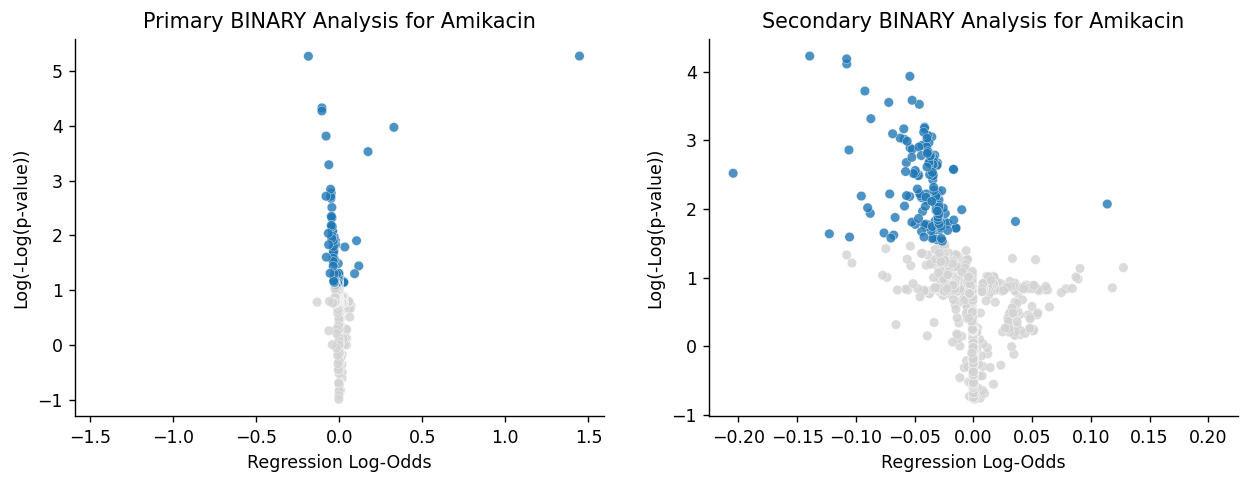

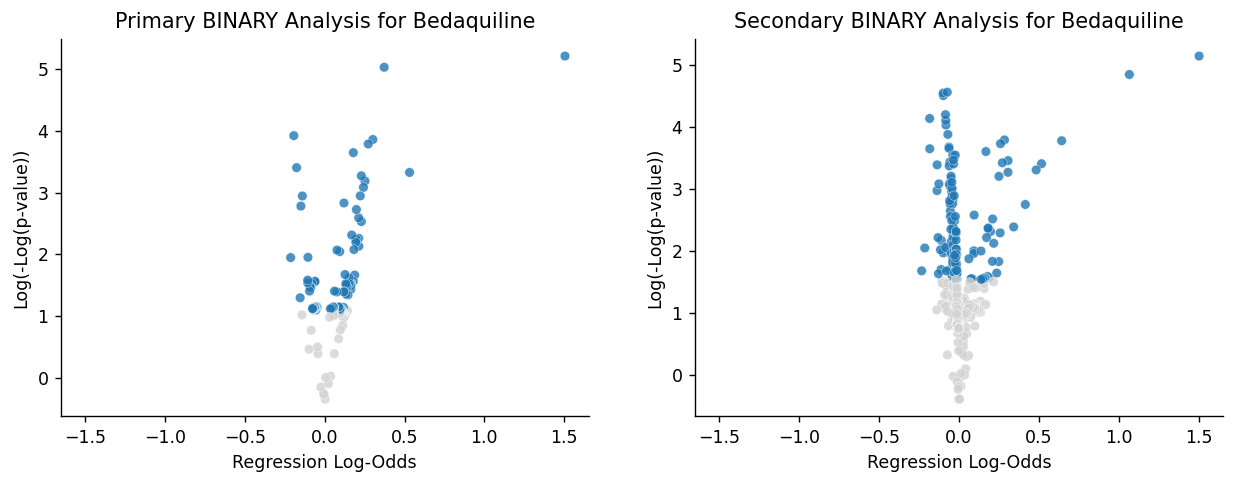

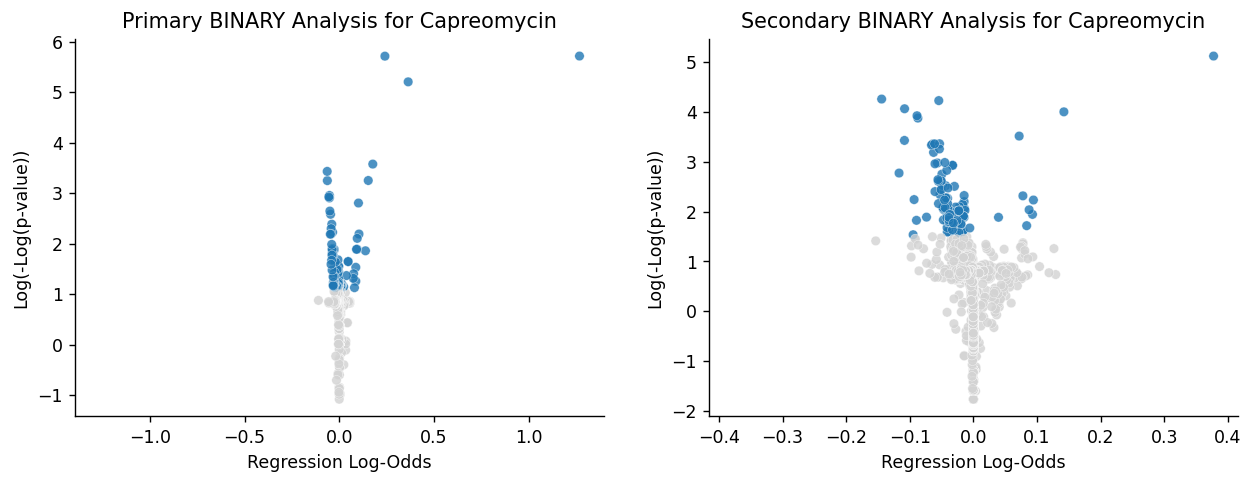

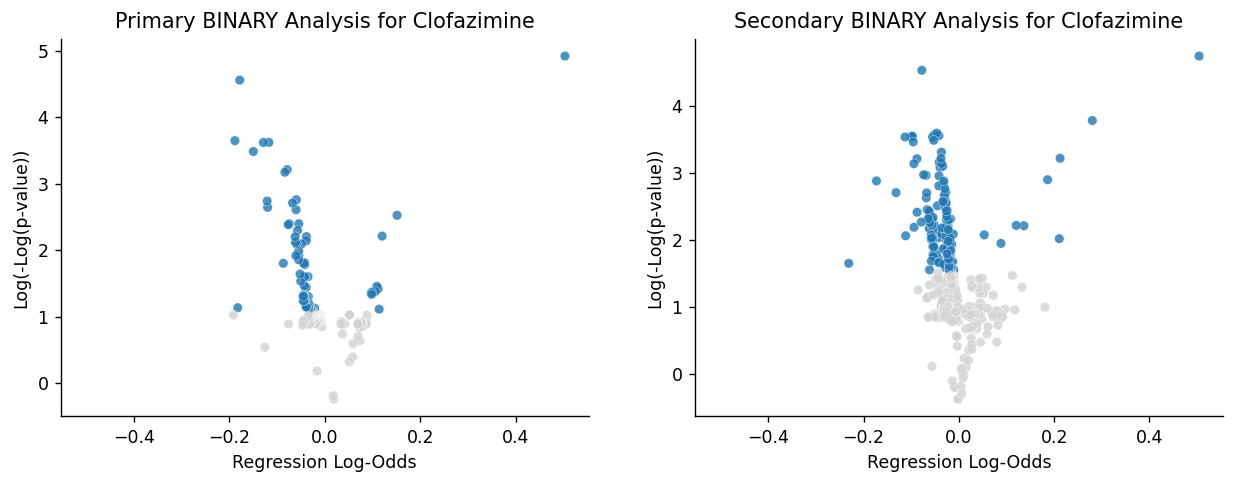

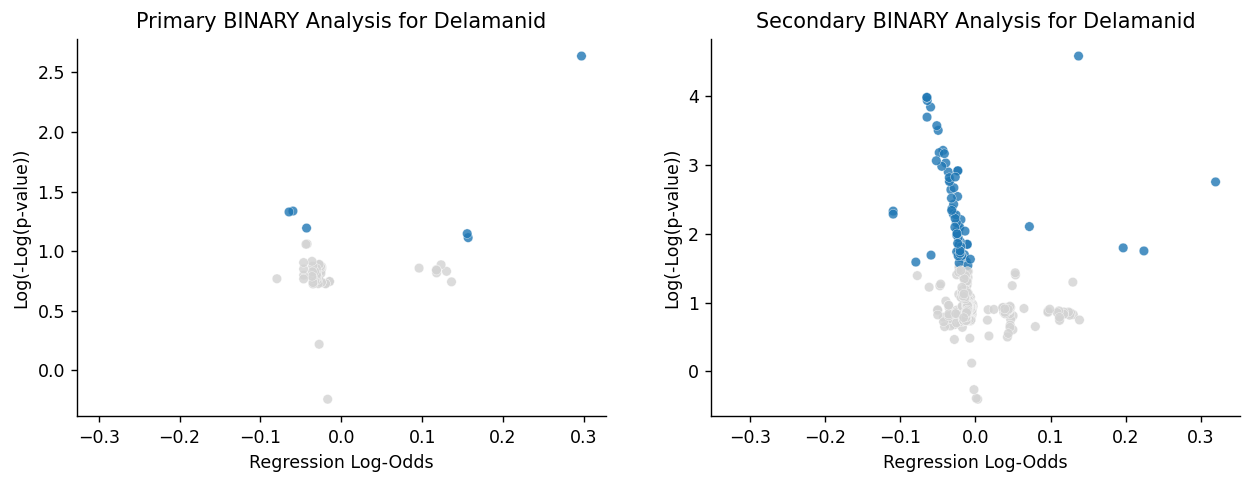

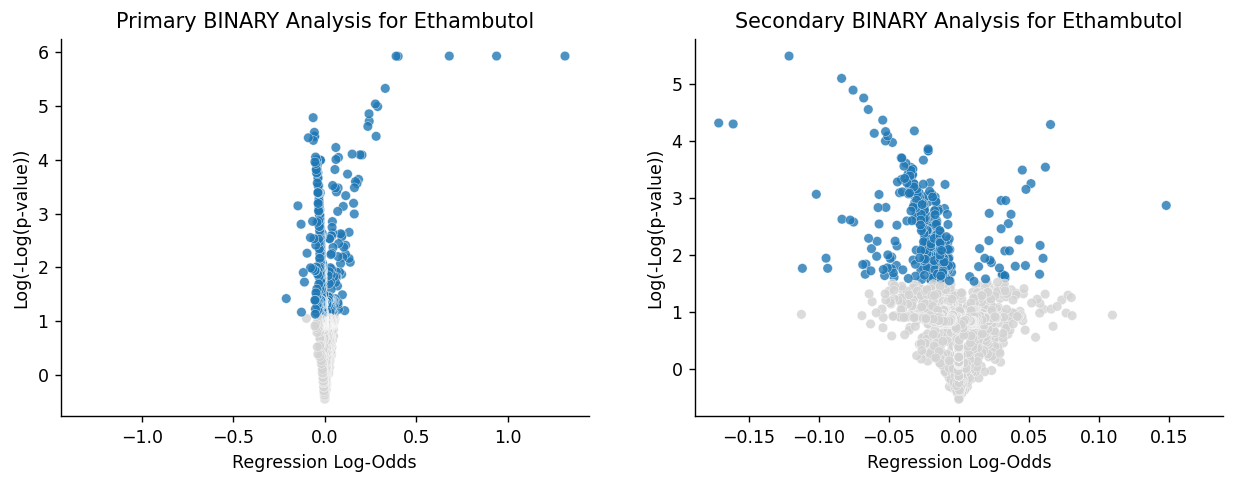

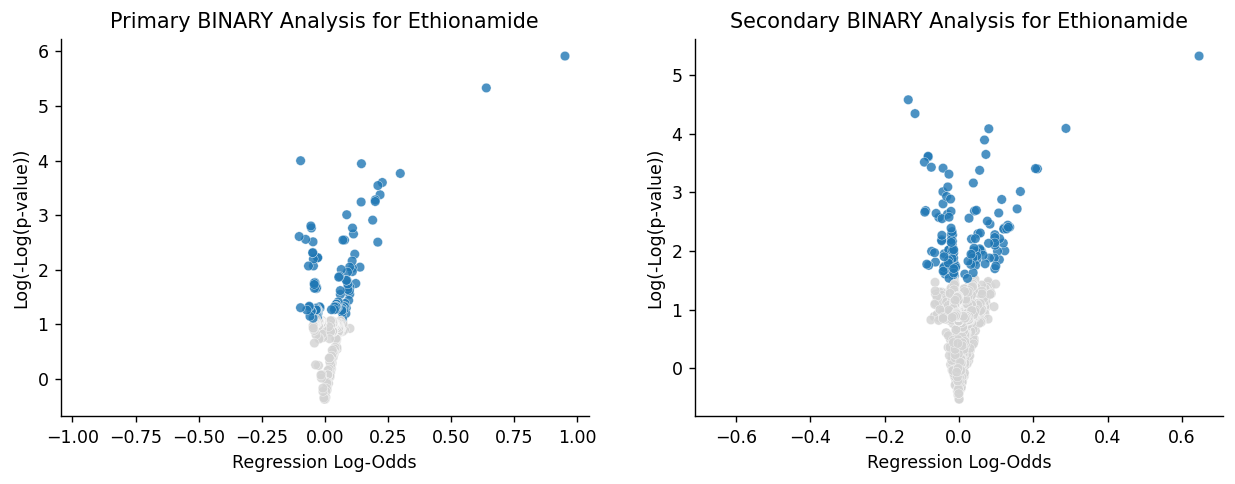

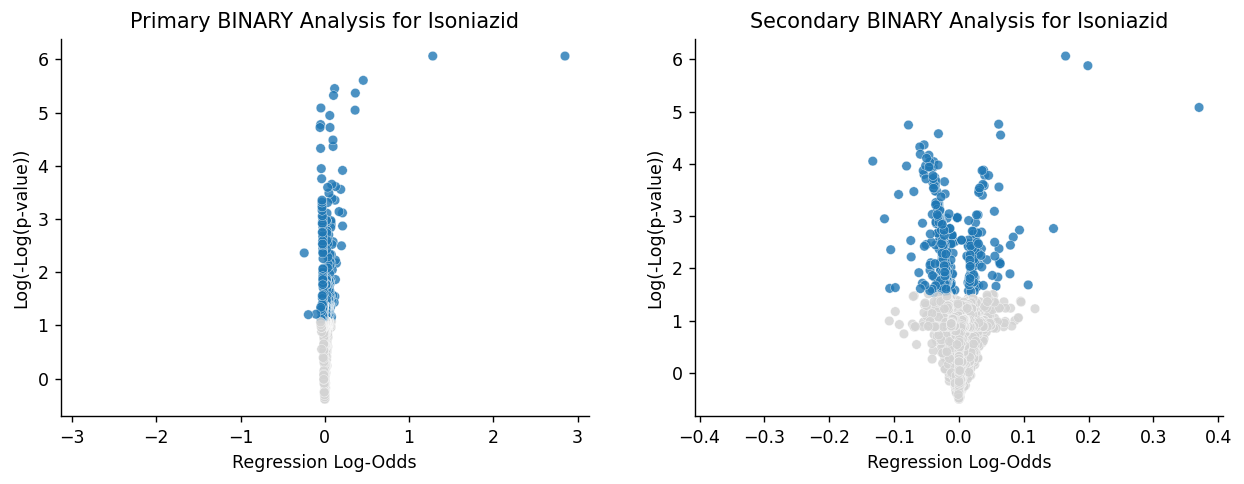

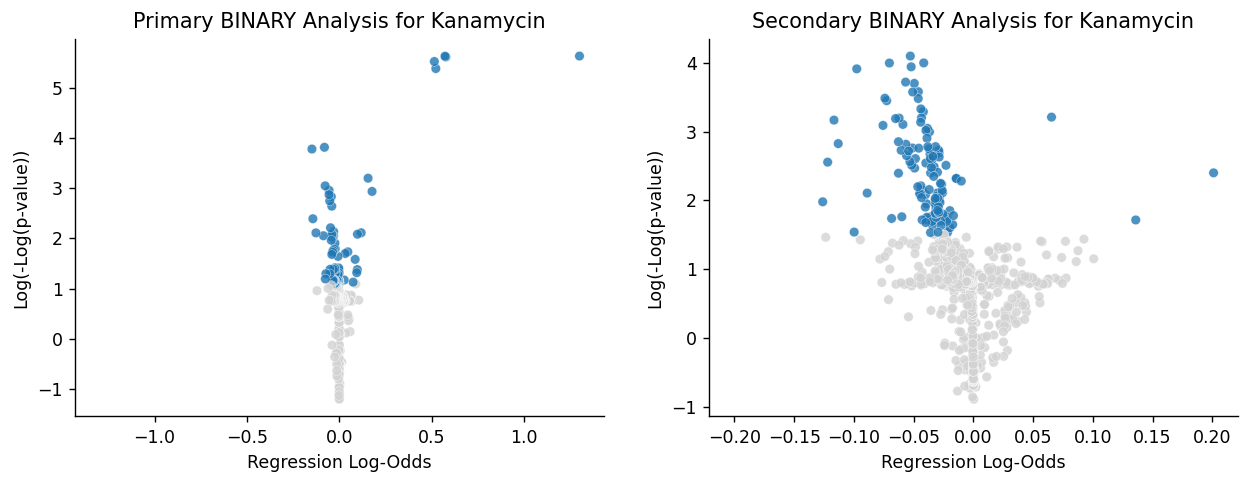

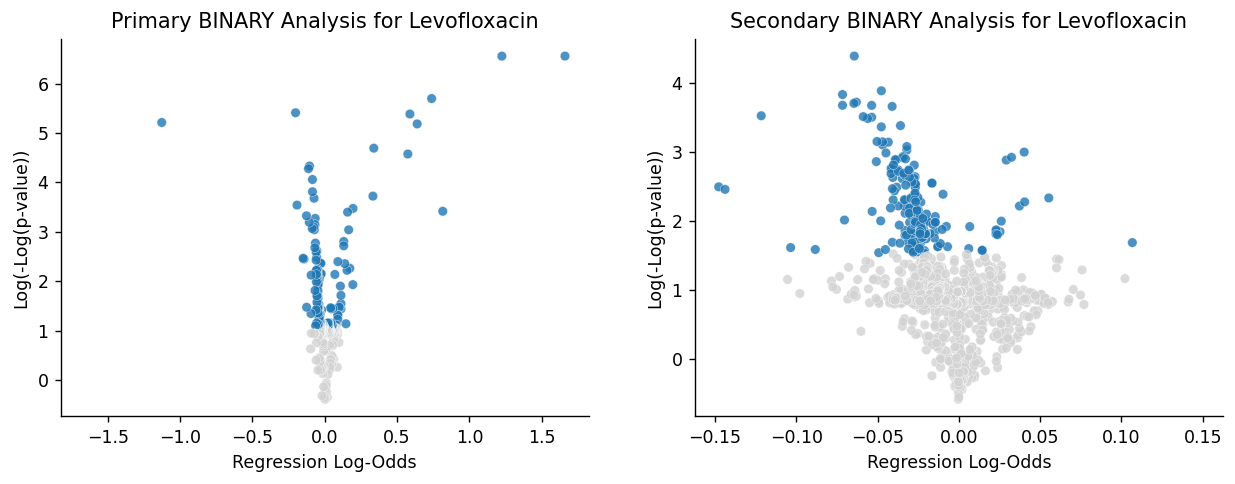

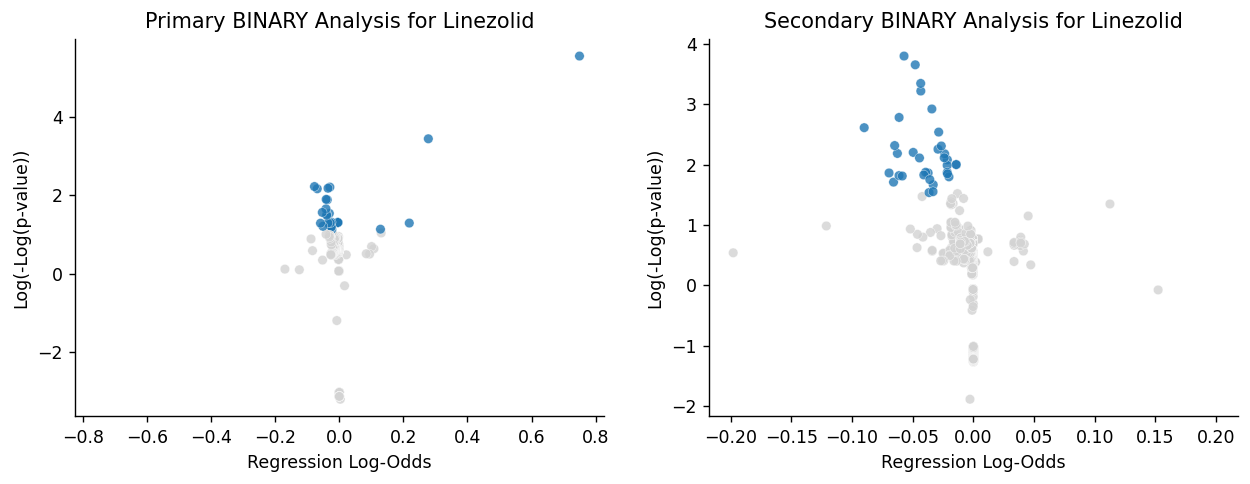

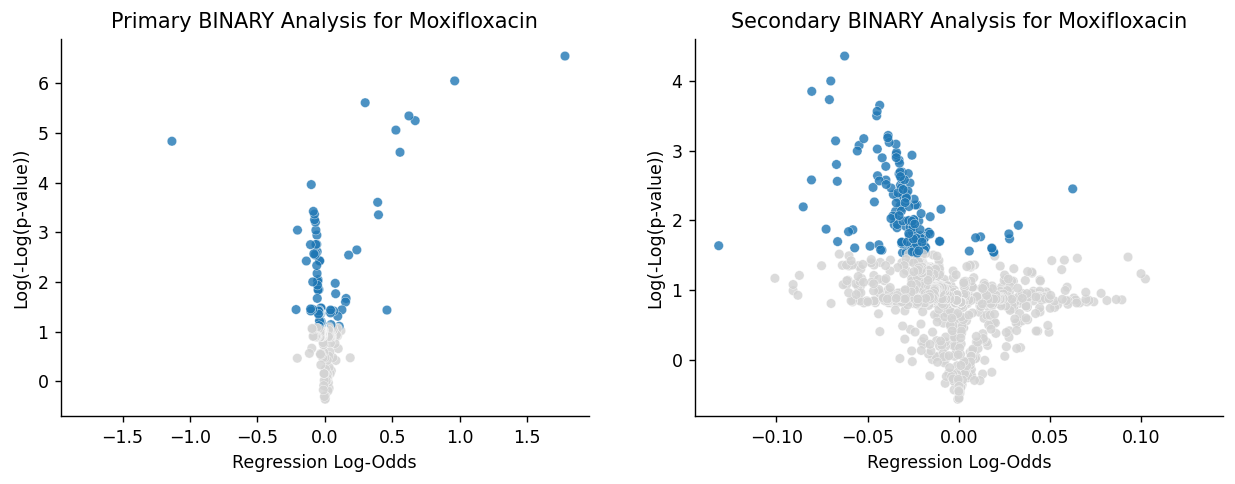

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


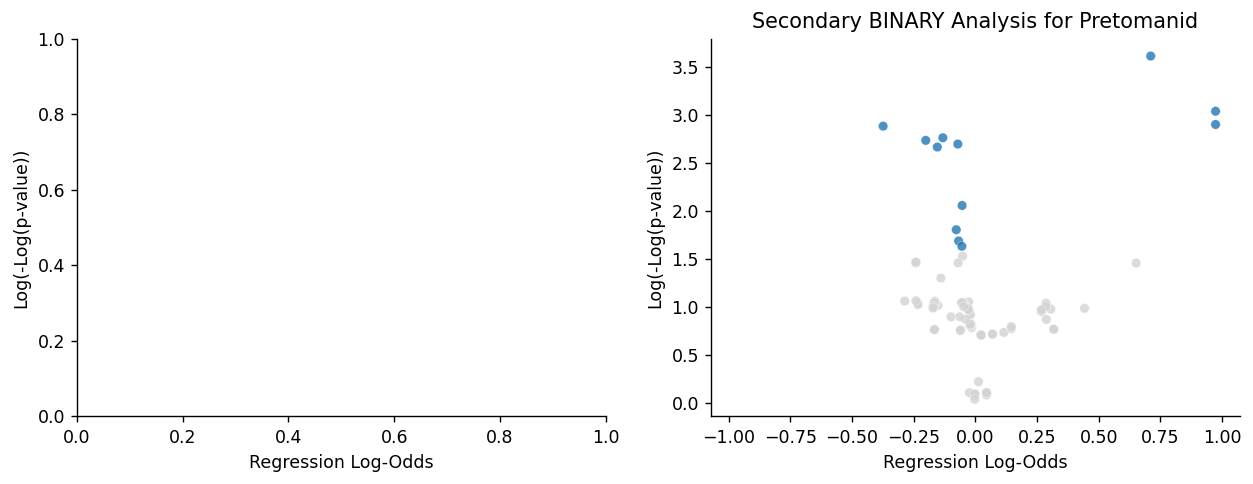

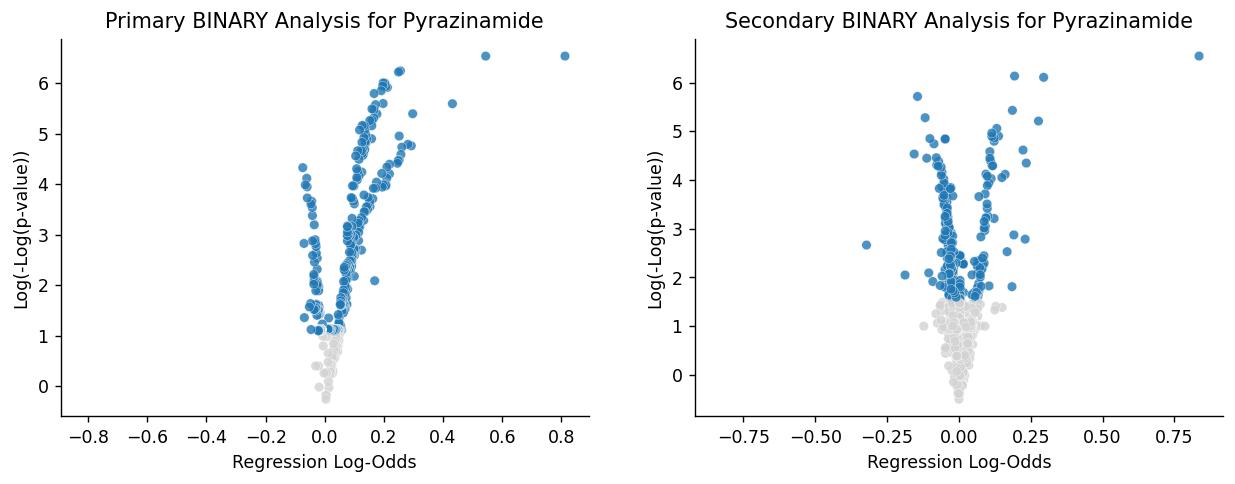

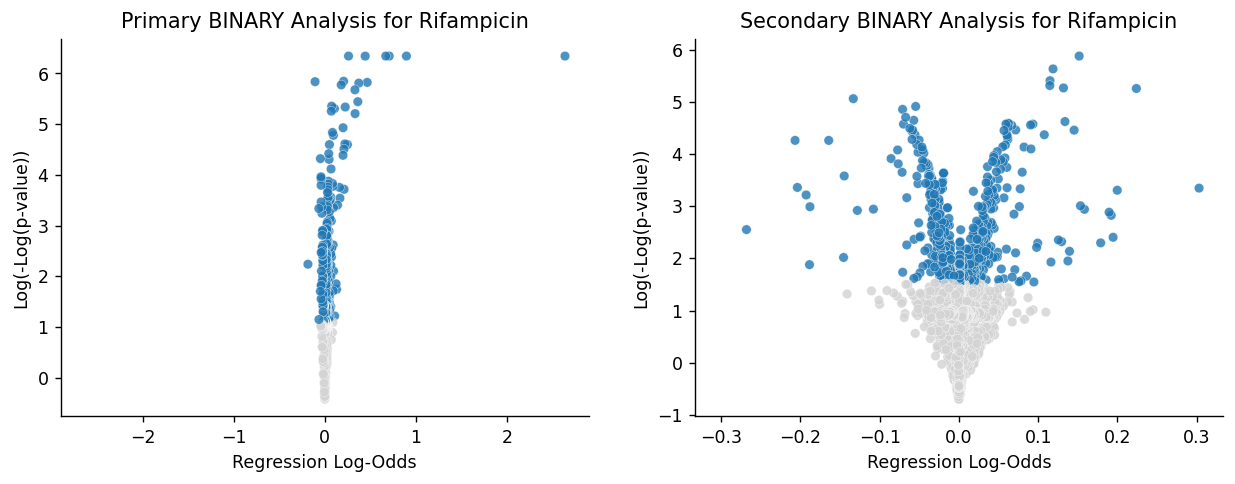

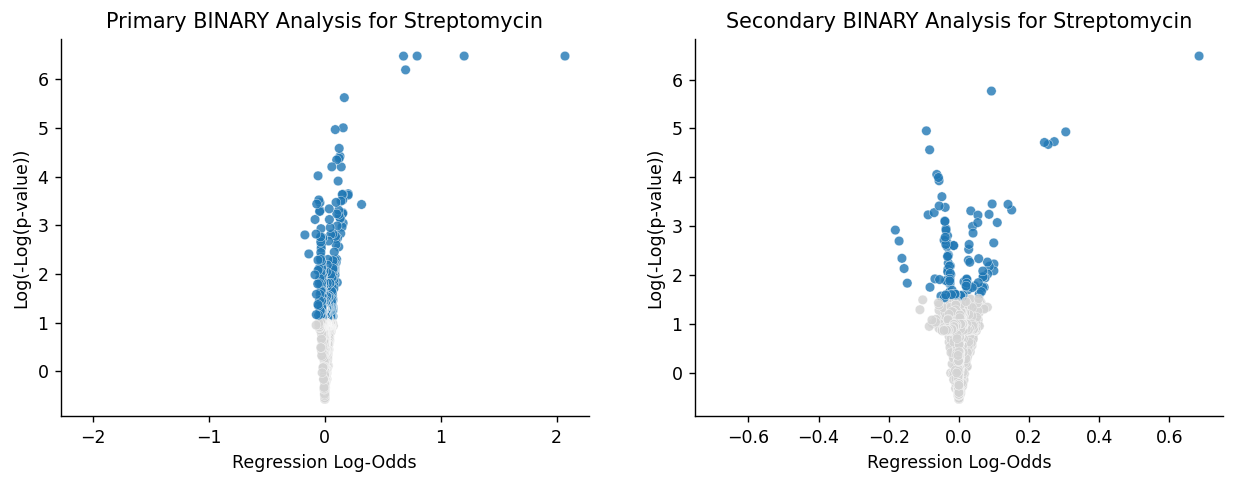

In [30]:
for drug in np.sort(drugs_lst):
    _ = volcano_plot(drug, "BINARY", "log_neg_log_pval", "BH_pval")#saveFig=f"../results/{drug}_volcano.png")